In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


data = pd.read_csv('Fraud_Detection.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [11]:
data.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


Number of anomalies detected: 17513


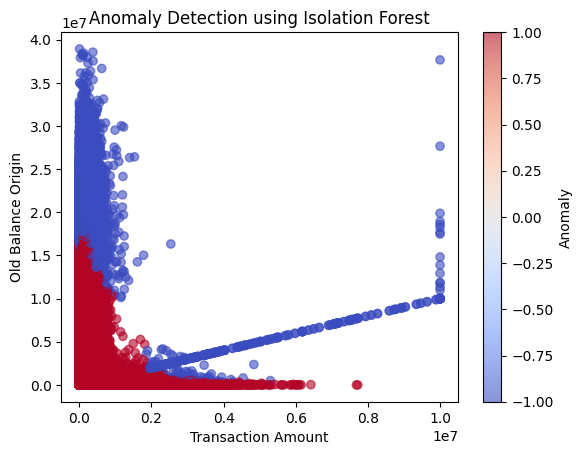

In [14]:
from sklearn.ensemble import IsolationForest

# Select relevant features for anomaly detection
features = data[['amount', 'oldbalanceOrg', 'newbalanceOrig']]

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)  # 1% contamination
data['anomaly'] = iso_forest.fit_predict(scaled_features)

# Transactions flagged as -1 are anomalies (potential frauds)
anomalies = data[data['anomaly'] == -1]

# Check the count of anomalies
print(f"Number of anomalies detected: {len(anomalies)}")

# Visualize anomalies in the context of amount and old balance
plt.scatter(data['amount'], data['oldbalanceOrg'], c=data['anomaly'], cmap='coolwarm', alpha=0.6)
plt.title('Anomaly Detection using Isolation Forest')
plt.xlabel('Transaction Amount')
plt.ylabel('Old Balance Origin')
plt.colorbar(label='Anomaly')
plt.show()


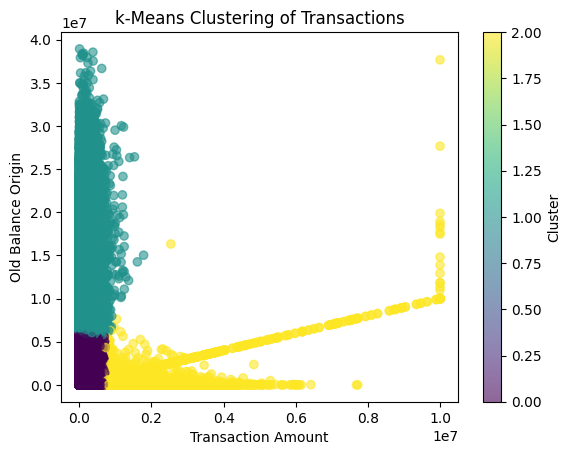

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Select relevant features for clustering
features = data[['amount', 'oldbalanceOrg', 'newbalanceOrig']]

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply k-Means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
data['cluster'] = kmeans.fit_predict(scaled_features)

# Visualize the clusters
plt.scatter(data['amount'], data['oldbalanceOrg'], c=data['cluster'], cmap='viridis', alpha=0.6)
plt.title('k-Means Clustering of Transactions')
plt.xlabel('Transaction Amount')
plt.ylabel('Old Balance Origin')
plt.colorbar(label='Cluster')
plt.show()


In [17]:
data["type"] = data["type"].map({"CASH_OUT": 1, "PAYMENT": 2,
                                 "CASH_IN": 3, "TRANSFER": 4,
                                 "DEBIT": 5})

In [18]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Assume 'data' is your dataset
# Drop irrelevant columns: 'nameOrig', 'nameDest' (unique to each transaction), and 'isFlaggedFraud'
X = data.drop(['isFraud', 'nameDest', 'nameOrig', 'isFlaggedFraud'], axis=1)
y = data['isFraud']  # Target variable: Fraud flag

#Handling Class Imbalance
#The dataset is imbalanced since fraudulent transactions make up only a small portion using  SMOTE
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Output the shape of the original and resampled datasets to check the balancing
print(f"Original dataset shape: {X.shape}")
print(f"Resampled dataset shape: {X_resampled.shape}")


Original dataset shape: (6362620, 8)
Resampled dataset shape: (12708814, 8)


In [19]:
# Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Train a Logistic Regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.90      0.91      0.91   1906309
           1       0.91      0.90      0.91   1906336

    accuracy                           0.91   3812645
   macro avg       0.91      0.91      0.91   3812645
weighted avg       0.91      0.91      0.91   3812645

Accuracy: 0.9067767914400633


In [ ]:
#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# Train a Decision Tree model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_dt = dt.predict(X_test)
print(classification_report(y_test, y_pred_dt))
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt)}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906309
           1       1.00      1.00      1.00   1906336

    accuracy                           1.00   3812645
   macro avg       1.00      1.00      1.00   3812645
weighted avg       1.00      1.00      1.00   3812645

Accuracy: 0.999587687812529


In [ ]:
# Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)  # Default number of trees = 100
rf.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_rf = rf.predict(X_test)

# Print classification report and accuracy
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")

              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1906309
           1       0.99      1.00      0.99   1906336

    accuracy                           0.99   3812645
   macro avg       0.99      0.99      0.99   3812645
weighted avg       0.99      0.99      0.99   3812645

Accuracy: 0.9910802080970035


In [20]:
# Unsupervised Learning

from sklearn.ensemble import IsolationForest

# Train an Isolation Forest model for anomaly detection
iso_forest = IsolationForest(contamination=0.01)
y_pred_if = iso_forest.fit_predict(X)

# Convert anomaly labels (-1 for outliers) to binary classification (1 for fraud, 0 for normal)
y_pred_if = [1 if x == -1 else 0 for x in y_pred_if]

# Evaluate anomaly detection results
print(classification_report(y, y_pred_if))
print(f"Accuracy: {accuracy_score(y, y_pred_if)}")

              precision    recall  f1-score   support

           0       1.00      0.99      0.99   6354407
           1       0.01      0.07      0.02      8213

    accuracy                           0.99   6362620
   macro avg       0.50      0.53      0.51   6362620
weighted avg       1.00      0.99      0.99   6362620

Accuracy: 0.9888872822830846


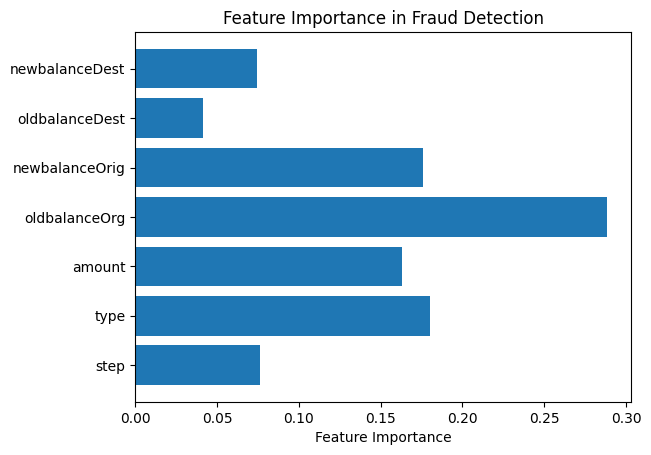

In [21]:
#Feature Importance
import matplotlib.pyplot as plt

# Plot feature importance for Random Forest model
importances = rf.feature_importances_
feature_names = X.columns

plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Fraud Detection')
plt.show()
plt.savefig('Feature Importance in Fraud Detection.png')